In [1]:
import torch
import torchvision
from sklearn.model_selection import train_test_split

# Download MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=None, target_transform=None, download=True)

In [2]:
# Convert PyTorch tensors to numpy arrays
X_train = train_dataset.data.numpy()
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()

# Reshape the images to 28x28 format
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10000, random_state=42)

<font size='10'>Second feature selection method based on selecting edges of digits (their number and positions)</font>

In [3]:
# function which tranform vector with values from range(0,255) to vector with values 0,1
def thresholdPixels(elem):
    arr = []
    for i in range(28):
        for j in range(28):
            if elem[i][j] > 50:
                arr.append(1)
            else:
                arr.append(0)
    # coonvert to numpy array for future processing
    res = np.array(arr)
    return res

In [96]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
X_trainTresholded = list(range(len(X_train)))
X_testTresholded = list(range(len(X_test)))

for index, value in enumerate(X_train):
    X_trainTresholded[index] = thresholdPixels(value)
    
for index, value in enumerate(X_test):
    X_testTresholded[index] = thresholdPixels(value)

In [30]:
len(X_trainTresholded)

50000

In [31]:
len(X_trainTresholded[0])

28

In [32]:
len(X_trainTresholded[0][0])

28

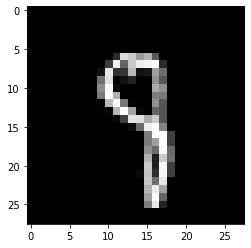

In [6]:
plt.imshow(X_train[0], cmap='gray')
plt.show()

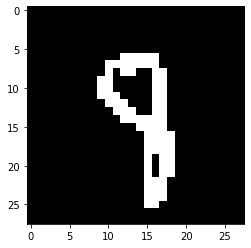

In [7]:
tmp2 = np.array(X_trainTresholded)
tmp = tmp2.reshape(-1, 28, 28)
plt.imshow(tmp[0], cmap='gray')
plt.show()

In [39]:
# we are taking one pixel and check if number of his neighbours with value 1 is <= 4
def getEdges(Matrix):
    arr = []
    for i in range(28):
        for j in range(28):
            numOf1s = 0
            if i==0 or j==0 or i==27 or j==27:
                arr.append(0)
                continue
            else:
                # top-left
                if Matrix[i-1][j-1]==1:
                    numOf1s+=1
                # top
                if Matrix[i-1][j]==1:
                    numOf1s+=1
                # top-right
                if Matrix[i-1][j+1]==1:
                    numOf1s+=1
                # right
                if Matrix[i][j+1]==1:
                    numOf1s+=1
                # bottom-right
                if Matrix[i+1][j+1]==1:
                    numOf1s+=1
                # bottom
                if Matrix[i+1][j]==1:
                    numOf1s+=1
                # bottom-left
                if Matrix[i+1][j-1]==1:
                    numOf1s+=1
                # left
                if Matrix[i][j-1]==1:
                    numOf1s+=1
                # check how many 1s occured
            if numOf1s < 4:
                arr.append(1)
            else:
                arr.append(0)
    return arr

In [51]:
X_trainTresholded = np.array(X_trainTresholded)
X_testTresholded = np.array(X_testTresholded)

X_trainTresholded = X_trainTresholded.reshape(-1, 28, 28)
X_testTresholded = X_testTresholded.reshape(-1, 28, 28)

X_trainEdges = list(range(len(X_train)))
X_testEdges = list(range(len(X_test)))

for index, value in enumerate(X_trainTresholded):
    X_trainEdges[index] = getEdges(value)
    
for index, value in enumerate(X_testTresholded):
    X_testEdges[index] = getEdges(value)

In [50]:
len(X_trainEdges)

392000

In [42]:
len(X_trainEdges[0])

784

In [52]:
X_trainEdges = np.array(X_trainEdges)
X_testEdges = np.array(X_testEdges)

In [53]:
X_trainEdges = X_trainEdges.reshape(-1, 784)
X_testEdges = X_testEdges.reshape(-1, 784)

In [54]:
from sklearn.neighbors import KNeighborsClassifier

In [62]:
from sklearn.model_selection import GridSearchCV

In [83]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [1, 5, 25, 50],
    'weights': ['uniform', 'distance'],
}

gridKnn = GridSearchCV(knn, param_grid, scoring='accuracy', cv=5)

In [84]:
gridKnn.fit(X_trainEdges, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 5, 25, 50],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [85]:
# Print the best hyperparameters and score
print("Best parameters: ", gridKnn.best_params_)
print("Best accuracy score: ", gridKnn.best_score_)

Best parameters:  {'n_neighbors': 5, 'weights': 'distance'}
Best accuracy score:  0.96404


In [86]:
import pandas as pd

cv_results = pd.DataFrame(gridKnn.cv_results_)
print(cv_results[['params', 'mean_test_score', 'std_test_score']])

                                       params  mean_test_score  std_test_score
0    {'n_neighbors': 1, 'weights': 'uniform'}          0.96056        0.001198
1   {'n_neighbors': 1, 'weights': 'distance'}          0.96056        0.001198
2    {'n_neighbors': 5, 'weights': 'uniform'}          0.96306        0.001617
3   {'n_neighbors': 5, 'weights': 'distance'}          0.96404        0.001667
4   {'n_neighbors': 25, 'weights': 'uniform'}          0.95144        0.001513
5  {'n_neighbors': 25, 'weights': 'distance'}          0.95238        0.001493
6   {'n_neighbors': 50, 'weights': 'uniform'}          0.94314        0.002002
7  {'n_neighbors': 50, 'weights': 'distance'}          0.94388        0.001812


In [87]:
knnPredictions = gridKnn.best_estimator_.predict(X_testEdges)

In [88]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [93]:
print("Accuracy: " + str(accuracy_score(y_test, knnPredictions)))
print("Precision(weighted): " + str(precision_score(y_test, knnPredictions, average='weighted')))
print("Precision(macro): " + str(precision_score(y_test, knnPredictions, average='macro')))
print("Recall(weighted): " + str(recall_score(y_test, knnPredictions, average='weighted')))
print("Recall(macro): " + str(recall_score(y_test, knnPredictions, average='macro')))
print("F1(weighted): " + str(f1_score(y_test, knnPredictions, average='weighted')))
print("F1(macro): " + str(f1_score(y_test, knnPredictions, average='macro')))

Accuracy: 0.9631
Precision(weighted): 0.9634585719932119
Precision(macro): 0.9638159742925219
Recall(weighted): 0.9631
Recall(macro): 0.9624702673560204
F1(weighted): 0.9630557149953205
F1(macro): 0.9629213152850973


In [103]:
indexes = []
for i in range(len(y_test)):
    if y_test[i] != knnPredictions[i]:
        indexes.append(i)
        break
for i in range(len(y_test)):
    if y_test[-i] != knnPredictions[-i]:
        indexes.append(-i)
        break

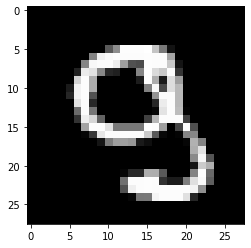

In [97]:
plt.imshow(X_test[indexes[0]], cmap='gray')
plt.show()

In [98]:
print(knnPredictions[indexes[0]])

8


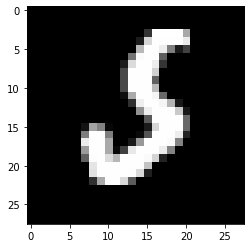

In [104]:
plt.imshow(X_test[indexes[1]], cmap='gray')
plt.show()

In [107]:
print(y_test[indexes[1]])

5


In [105]:
print(knnPredictions[indexes[1]])

6


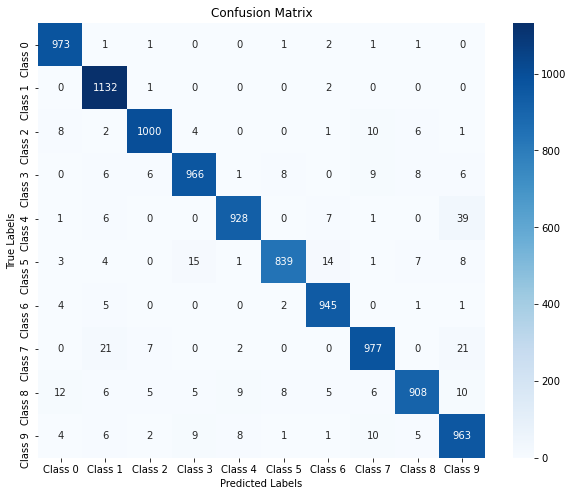

In [113]:
cm = confusion_matrix(y_test, knnPredictions)
# Define class labels
classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']
# Set the size of the figure
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes, ax=ax)
# Add labels and title to plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display plot
plt.show()

In [92]:
from sklearn.neural_network import MLPClassifier

In [74]:
# Create an instance of the MLPClassifier
mlp = MLPClassifier(max_iter=1000)

param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['relu', 'logistic', 'tanh'],
    'solver': ['sgd', 'adam'],
}

grid = GridSearchCV(mlp, param_grid, scoring='accuracy', cv=5)

In [75]:
grid.fit(X_trainEdges, y_train)

C:\Users\MICHU13\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\MICHU13\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\MICHU13\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\MICHU13\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\MICHU13\anaconda3\lib\site-packages\sklearn\neural_

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000),
             param_grid={'activation': ['relu', 'logistic', 'tanh'],
                         'hidden_layer_sizes': [(10,), (50,), (100,)],
                         'solver': ['sgd', 'adam']},
             scoring='accuracy')

In [76]:
# Print the best hyperparameters and score
print("Best parameters: ", grid.best_params_)
print("Best accuracy score: ", grid.best_score_)

Best parameters:  {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'solver': 'sgd'}
Best accuracy score:  0.9643599999999999


In [109]:
cv_results = pd.DataFrame(grid.cv_results_)
print(cv_results[['params', 'mean_test_score']])

                                               params  mean_test_score
0   {'activation': 'relu', 'hidden_layer_sizes': (...          0.89690
1   {'activation': 'relu', 'hidden_layer_sizes': (...          0.86556
2   {'activation': 'relu', 'hidden_layer_sizes': (...          0.95504
3   {'activation': 'relu', 'hidden_layer_sizes': (...          0.94498
4   {'activation': 'relu', 'hidden_layer_sizes': (...          0.96142
5   {'activation': 'relu', 'hidden_layer_sizes': (...          0.95728
6   {'activation': 'logistic', 'hidden_layer_sizes...          0.91816
7   {'activation': 'logistic', 'hidden_layer_sizes...          0.91640
8   {'activation': 'logistic', 'hidden_layer_sizes...          0.95350
9   {'activation': 'logistic', 'hidden_layer_sizes...          0.95318
10  {'activation': 'logistic', 'hidden_layer_sizes...          0.95716
11  {'activation': 'logistic', 'hidden_layer_sizes...          0.96350
12  {'activation': 'tanh', 'hidden_layer_sizes': (...          0.91678
13  {'

In [110]:
cv_results.to_csv('MLP.txt', sep='\t', index=False)

In [111]:
mlpPredictions = grid.best_estimator_.predict(X_testEdges)

In [112]:
print("Accuracy: " + str(accuracy_score(y_test, mlpPredictions)))
print("Precision(weighted): " + str(precision_score(y_test, mlpPredictions, average='weighted')))
print("Precision(macro): " + str(precision_score(y_test, mlpPredictions, average='macro')))
print("Recall(weighted): " + str(recall_score(y_test, mlpPredictions, average='weighted')))
print("Recall(macro): " + str(recall_score(y_test, mlpPredictions, average='macro')))
print("F1(weighted): " + str(f1_score(y_test, mlpPredictions, average='weighted')))
print("F1(macro): " + str(f1_score(y_test, mlpPredictions, average='macro')))

Accuracy: 0.9686
Precision(weighted): 0.9686775351523311
Precision(macro): 0.9686001507868459
Recall(weighted): 0.9686
Recall(macro): 0.9681688521629461
F1(weighted): 0.9685759936759607
F1(macro): 0.9683207450941019


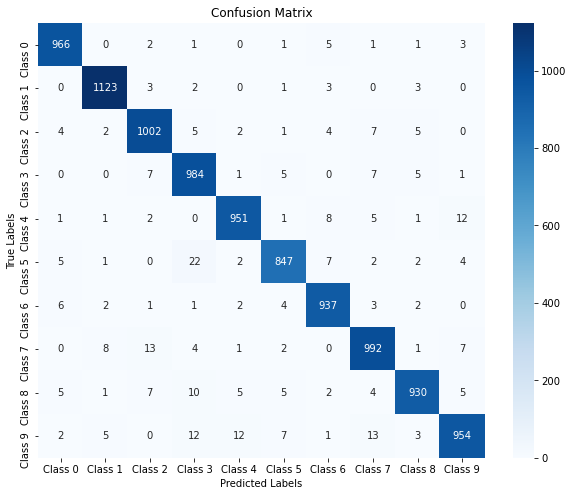

In [114]:
cm = confusion_matrix(y_test, mlpPredictions)
# Define class labels
classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']
# Set the size of the figure
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes, ax=ax)
# Add labels and title to plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display plot
plt.show()

In [115]:
indexes = []
for i in range(len(y_test)):
    if y_test[i] != mlpPredictions[i]:
        indexes.append(i)
        break
for i in range(len(y_test)):
    if y_test[-i] != mlpPredictions[-i]:
        indexes.append(-i)
        break

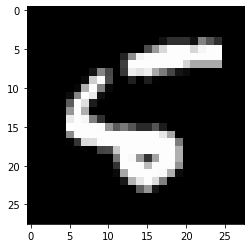

In [116]:
plt.imshow(X_test[indexes[0]], cmap='gray')
plt.show()

In [117]:
print(y_test[indexes[0]])

5


In [118]:
print(mlpPredictions[indexes[0]])

6


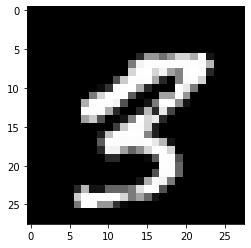

In [119]:
plt.imshow(X_test[indexes[1]], cmap='gray')
plt.show()

In [120]:
print(y_test[indexes[1]])

3


In [121]:
print(mlpPredictions[indexes[1]])

8


In [78]:
from sklearn.svm import SVC

In [79]:
# Create an instance of the MLPClassifier
svc = SVC()

param_grid = {
    'C': [1, 10, 50, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

gridSVC = GridSearchCV(svc, param_grid, scoring='accuracy', cv=5)

In [80]:
gridSVC.fit(X_trainEdges, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10, 50, 100],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [81]:
# Print the best hyperparameters and score
print("Best parameters: ", gridSVC.best_params_)
print("Best accuracy score: ", gridSVC.best_score_)

Best parameters:  {'C': 10, 'kernel': 'rbf'}
Best accuracy score:  0.9718


In [82]:
cv_results = pd.DataFrame(gridSVC.cv_results_)
print(cv_results[['params', 'mean_test_score', 'std_test_score']])

                             params  mean_test_score  std_test_score
0      {'C': 1, 'kernel': 'linear'}          0.91506        0.001488
1        {'C': 1, 'kernel': 'poly'}          0.96518        0.000954
2         {'C': 1, 'kernel': 'rbf'}          0.96444        0.001348
3     {'C': 1, 'kernel': 'sigmoid'}          0.61012        0.003055
4     {'C': 10, 'kernel': 'linear'}          0.90428        0.001076
5       {'C': 10, 'kernel': 'poly'}          0.96334        0.000794
6        {'C': 10, 'kernel': 'rbf'}          0.97180        0.000938
7    {'C': 10, 'kernel': 'sigmoid'}          0.48322        0.004337
8     {'C': 50, 'kernel': 'linear'}          0.90148        0.001434
9       {'C': 50, 'kernel': 'poly'}          0.96326        0.000828
10       {'C': 50, 'kernel': 'rbf'}          0.97110        0.000876
11   {'C': 50, 'kernel': 'sigmoid'}          0.52598        0.027396
12   {'C': 100, 'kernel': 'linear'}          0.90036        0.001164
13     {'C': 100, 'kernel': 'poly'

In [122]:
svcPredictions = gridSVC.best_estimator_.predict(X_testEdges)

In [123]:
print("Accuracy: " + str(accuracy_score(y_test, svcPredictions)))
print("Precision(weighted): " + str(precision_score(y_test, svcPredictions, average='weighted')))
print("Precision(macro): " + str(precision_score(y_test, svcPredictions, average='macro')))
print("Recall(weighted): " + str(recall_score(y_test, svcPredictions, average='weighted')))
print("Recall(macro): " + str(recall_score(y_test, svcPredictions, average='macro')))
print("F1(weighted): " + str(f1_score(y_test, svcPredictions, average='weighted')))
print("F1(macro): " + str(f1_score(y_test, svcPredictions, average='macro')))

Accuracy: 0.9746
Precision(weighted): 0.9746338938996453
Precision(macro): 0.9746850269064437
Recall(weighted): 0.9746
Recall(macro): 0.974209137511556
F1(weighted): 0.9745731117374252
F1(macro): 0.974402771103434


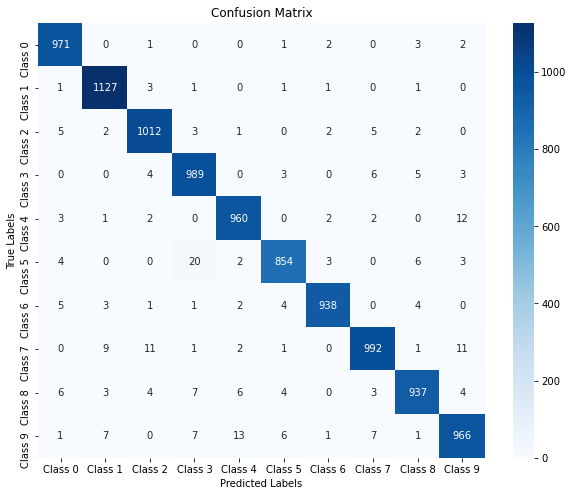

In [125]:
cm = confusion_matrix(y_test, svcPredictions)
# Define class labels
classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']
# Set the size of the figure
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes, ax=ax)
# Add labels and title to plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display plot
plt.show()

In [126]:
indexes = []
for i in range(len(y_test)):
    if y_test[i] != svcPredictions[i]:
        indexes.append(i)
        break
for i in range(len(y_test)):
    if y_test[-i] != svcPredictions[-i]:
        indexes.append(-i)
        break

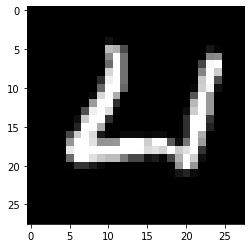

In [127]:
plt.imshow(X_test[indexes[0]], cmap='gray')
plt.show()

In [128]:
print(y_test[indexes[0]])

4


In [129]:
print(svcPredictions[indexes[0]])

0


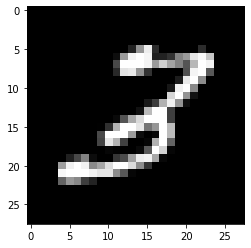

In [130]:
plt.imshow(X_test[indexes[1]], cmap='gray')
plt.show()

In [131]:
print(y_test[indexes[1]])

3


In [132]:
print(svcPredictions[indexes[1]])

8
